In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
import os
os.chdir("/data/projects/kwangeun/CVAR/datahub/WWW_data/movielens")

In [3]:
text_features_org = np.load("./text_features.npy", allow_pickle=True)
print(text_features_org.shape) # num_ids, 2
print(text_features_org[0].shape) # id, feature
print(text_features_org[0][1].shape) # feature_size
text_emb_size = text_features_org[0][1].shape[0]
text_features = {f[0]: f[1] for f in text_features_org}

(5040, 2)
(2,)
(768,)


In [4]:
with open("./video_features.pkl", "rb") as pf:
    video_features = pickle.load(pf)
video_emb_size = video_features[1].shape[0]

In [5]:
warm_train = pd.read_csv("./warm_train.csv")
cold_val = pd.read_csv("./cold_val.csv")
cold_test = pd.read_csv("./cold_test.csv")
warm_items = warm_train["movielens_id"].unique()
cold_val_items = cold_val["movielens_id"].unique()
cold_test_items = cold_test["movielens_id"].unique()
all_items = np.concatenate([warm_items, cold_val_items, cold_test_items], axis=0)

In [6]:
# implicit feedback with rating
threshold = 3.5
ratings = pd.read_csv("./ratings_tv.csv")
ratings['rating'] = ratings['rating'].map(lambda x: 0 if x < threshold else 1)
ratings.rename(columns={"movielens_id": "item_id", "userId": "user_id"}, inplace=True)

In [7]:
# filter items if not in warm and cold
ratings = ratings[ratings["item_id"].isin(all_items)]

In [8]:
content_features = ratings[["item_id"]].drop_duplicates().reset_index(drop=True)

# append text features
text = []
for item_id in content_features["item_id"]:
    text.append(text_features[item_id])
content_features["text"] = text

# append video features
video = []
for item_id in content_features["item_id"]:
    video.append(video_features[item_id])
content_features["video"] = video

content_features = {row.item_id: {"text": row.text, "video": row.video} for row in content_features.itertuples()}

In [10]:
# # densify index
# user_map = {user_id: idx for idx, user_id in enumerate(ratings["user_id"].unique())}
# item_map = {item_id: idx for idx, item_id in enumerate(ratings["item_id"].unique())}
# ratings["user_id"] = ratings["user_id"].map(user_map)
# ratings["item_id"] = ratings["item_id"].map(item_map)

# warm_items = np.array([item_map[item] for item in warm_items])
# cold_val_items = np.array([item_map[item] for item in cold_val_items])
# cold_test_items = np.array([item_map[item] for item in cold_test_items])

In [11]:
orders = ["user_id", "item_id", "rating"]
ratings = ratings[orders]
description = [
    ('user_id', np.max(ratings["user_id"]) + 1, 'spr'),
    ('item_id', np.max(ratings["item_id"]) + 1, 'spr'),
    ('text', text_emb_size, 'pretrained'),
    ('video', video_emb_size, 'pretrained'),
    ('rating', 2, 'label'),
    ('count', -1, 'ctn'),
]

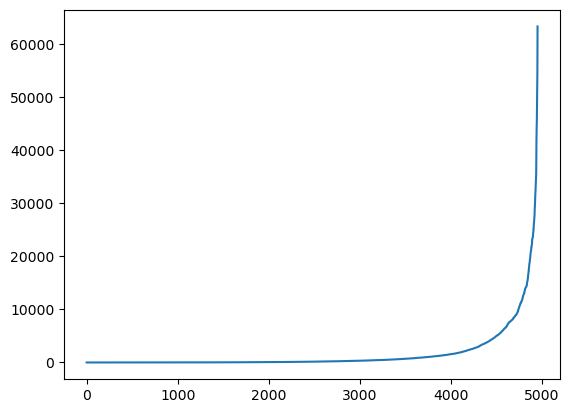

In [12]:
user2count = ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [13]:
# Preprocess count
ratings = ratings.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(ratings['count'])
max_count = np.max(ratings['count'])
ratings['count'] = ratings['count'].map(lambda x: (x - min_count)/(max_count - min_count))

In [14]:
# warm/cold, train/test/val split is based on item id
warm = ratings[ratings["item_id"].isin(warm_items)]
warm_train, warm_eval = train_test_split(warm, test_size=0.2, stratify=warm["rating"])
warm_val, warm_test = train_test_split(warm_eval, test_size=0.5, stratify=warm_eval["rating"])
warm_train.reset_index(drop=True, inplace=True)
warm_val.reset_index(drop=True, inplace=True)
warm_test.reset_index(drop=True, inplace=True)

In [15]:
cold_val = ratings[ratings["item_id"].isin(cold_val_items)]
cold_test = ratings[ratings["item_id"].isin(cold_test_items)]
cold_val = cold_val[cold_val["rating"] > 0]
cold_test = cold_test[cold_test["rating"] > 0]
cold_val.reset_index(drop=True, inplace=True)
cold_test.reset_index(drop=True, inplace=True)

In [16]:
# def get_all_pairs(eval_df):
#     item_feat = eval_df[["item_id", "count"]]
#     user_feat = eval_df[["user_id"]]
#     labels = eval_df[["item_id", "user_id", "rating"]]
#     user_feat.drop_duplicates(inplace=True)
#     item_feat.drop_duplicates(subset=["item_id"], inplace=True)

#     print("Make all pair set")
#     all_items = item_feat["item_id"].tolist()
#     user_feat["item_id"] = [all_items for _ in range(len(user_feat))]
#     user_feat = user_feat.explode("item_id")
    
#     print("Merge dataframes")
#     eval_df = pd.merge(user_feat, item_feat, how="left", on="item_id")
#     eval_df = pd.merge(eval_df, labels, how="left", on=["item_id", "user_id"])
#     eval_df["rating"] = eval_df["rating"].fillna(value=0)
#     return eval_df
# cold_val = get_all_pairs(cold_val)
# cold_test = get_all_pairs(cold_test)

In [17]:
save_dic = {
    "warm_train": warm_train,
    "warm_val": warm_val,
    "warm_test": warm_test,
    "cold_val": cold_val,
    "cold_test": cold_test,
    "description": description,
    "content_features": content_features,
}
for name, df in save_dic.items():
    print("{} size: {}".format(name, len(df)))
with open('./movielens_data.pkl', 'bw+') as f:
    pickle.dump(save_dic, f)

warm_train size: 3595820
warm_val size: 449478
warm_test size: 449478
cold_val size: 1178519
cold_test size: 1083210
description size: 6
content_features size: 4953
